# Import

In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the system pat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from script.data_handler import *

# Manual

In [2]:
OR_DATA_FILE_NAME = "OR_data.csv"
RAS_DATA_FILE_NAME = "RAS_Flight_Data.csv"
RAS_DATA_MACH_CD_FILE_NAME = "Ras__CD_Before_Raw.CSV"
DATA_DIRECTORY = "data"
MOTOR_NAME = "M1297"
ROCKET_LENGTH = 2860
ALTITUDE_INCREMENTS = 1000
VERTICAL_MOTION_INCREMENTS = 50
AVERAGE_THRUST = 0
MAX_MACH_RAS_OR_COMPARISON = 1

FLIGHT_PROFILE_PLOT_TITLE = f"{MOTOR_NAME} Motor - Vertical Motion vs Time"
# Columns to consider for vertical motion
VERTICAL_MOTION_COLUMNS = ['vertical_velocity', 'vertical_acceleration']

# Read CSV

In [3]:
# Get the current working directory (should be 'Notebooks')
cwd = os.getcwd()
# Go up one level to the project directory
project_dir = os.path.join(cwd, '..')
# Construct the path to the CSV file in the 'data' directory
or_csv_path = os.path.join(project_dir, DATA_DIRECTORY, OR_DATA_FILE_NAME)
# Normalize the path (optional but recommended)
or_csv_path = os.path.normpath(or_csv_path)

ras_csv_path = os.path.join(project_dir, DATA_DIRECTORY, RAS_DATA_FILE_NAME)
# Normalize the path (optional but recommended)
ras_csv_path = os.path.normpath(ras_csv_path)

ras_mach_cd_csv_path = os.path.join(
    project_dir, DATA_DIRECTORY, RAS_DATA_MACH_CD_FILE_NAME)
# Normalize the path (optional but recommended)
ras_mach_cd_csv_path = os.path.normpath(ras_mach_cd_csv_path)

dh = DataHandler(or_filepath=or_csv_path,
                 ras_cd_filepath=ras_mach_cd_csv_path, ras_file_path=ras_csv_path)
dh.rename_or_df_columns()
dh.rename_ras_df_columns()
dh.convert_ras_units_to_SI()
dh.rename_ras_mach_cd_df_columns()

display(dh.merged_df)
display(dh.ras_df)
display(dh.filtered_ras_df)

,time,altitude,vertical_velocity,vertical_acceleration,total_velocity,total_acceleration,position_east_of_launch,position_north_of_launch,lateral_distance,lateral_direction,...,reference_area,vertical_orientation_zenith,lateral_orientation_azimuth,wind_velocity,air_temperature,air_pressure,speed_of_sound,simulation_time_step,computation_time,event
0,0.010,-0.000769,-0.047,-4.685,0.047,4.685,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.220,15.000,1013.0,340.389,0.01,0.001,NaN
1,0.020,0.000907,0.055,5.533,0.055,5.533,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.232,15.000,1013.0,340.389,0.01,0.002,NaN
2,0.030,0.006562,0.213,15.756,0.213,15.756,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.244,15.000,1013.0,340.389,0.01,0.002,NaN
3,0.040,0.016404,0.473,25.984,0.473,25.984,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.256,15.000,1013.0,340.389,0.01,0.003,NaN
4,0.050,0.039370,0.835,36.218,0.835,36.218,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.268,15.000,1013.0,340.389,0.01,0.003,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,196.681,8.513780,-16.795,-0.389,27.233,0.397,-12323.809055,-70.098425,12324.009186,-179.679565,...,180.0,1.661578,0.916732,1.911,14.983,1013.0,340.379,0.05,1.235,NaN
3955,196.731,5.757874,-16.814,-0.399,27.248,0.410,-12327.326115,-70.150919,12327.526247,-179.679565,...,180.0,1.776169,0.916732,1.882,14.989,1013.0,340.382,0.05,1.236,NaN
3956,196.781,2.995407,-16.835,-0.415,27.265,0.429,-12330.843176,-70.200131,12331.043307,-179.679565,...,180.0,1.890761,0.916732,1.921,14.994,1013.0,340.385,0.05,1.236,NaN
3957,196.831,0.232940,-16.856,-0.416,27.282,0.434,-12334.360236,-70.252625,12334.560367,-179.679565,...,180.0,1.948057,0.916732,1.861,15.000,1013.0,340.389,0.05,1.236,NaN


,time,stage,stage_time,mach_number,angle_of_attack,drag_coefficient,lift_coefficient,thrust_imperial,weight_imperial,drag_force_imperial,...,drag_force,lift_force,cg_location,cp_location,total_acceleration,vertical_acceleration,horizontal_acceleration,total_velocity,vertical_velocity,horizontal_velocity
0,0.00000,S,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,30.94450,0.000000,...,0.000000,0.000000,1761.299500,2138.433112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,0.01000,S,0.01000,0.010000,0.00000,0.402410,0.000000,32.22412,30.94450,0.000000,...,0.000000,0.000000,1760.880400,2138.433112,0.405527,0.405527,0.000018,2.000471,0.004055,1.782359e-07
2,0.02000,S,0.02000,0.010000,0.00000,0.402410,0.000000,64.44825,30.94371,0.004088,...,1.854186,0.000000,1760.461554,2138.433112,10.616917,10.616917,0.000036,2.003502,0.110224,5.346942e-07
3,0.03000,S,0.03000,0.010000,0.00000,0.402410,0.000000,96.67237,30.94132,0.004100,...,1.859808,0.000000,1760.042454,2138.433112,20.831696,20.831696,0.000053,2.025670,0.318541,1.069434e-06
4,0.04000,S,0.04000,0.010000,0.00000,0.402410,0.000000,128.89650,30.93735,0.004191,...,1.901193,0.000000,1759.623862,2138.433112,31.050123,31.050123,0.000071,2.097038,0.629043,1.782519e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,51.92729,S,51.92729,0.463427,24.49427,0.371620,0.073274,0.00000,24.94350,23.432780,...,10629.109008,2095.957685,1576.966112,2138.433112,-1.866652,-0.585374,1.772492,157.682761,-157.658410,7.706499e-01
5194,51.93729,S,51.93729,0.463436,24.36141,0.371614,0.072896,0.00000,24.94350,23.437280,...,10631.150208,2085.564802,1576.966112,2138.433112,-1.856507,-0.583450,1.762443,157.688923,-157.664262,7.882744e-01
5195,51.94729,S,51.94729,0.463446,24.22286,0.371608,0.072500,0.00000,24.94350,23.441770,...,10633.186872,2074.683391,1576.966112,2138.433112,-1.845968,-0.581537,1.751974,157.695055,-157.670083,8.057940e-01
5196,51.95729,S,51.95729,0.463456,24.07862,0.371601,0.072088,0.00000,24.94350,23.446220,...,10635.205392,2063.311186,1576.966112,2138.433112,-1.835038,-0.579641,1.741086,157.701156,-157.675875,8.232048e-01


,mach_number,alpha,drag_coefficient,drag_coefficient_power_off,drag_coefficient_power_on,axial_force_coefficient_power_off,axial_force_coefficient_power_on,lift_coefficient,normal_force_coefficient,normal_force_coefficient_potential,normal_force_coefficient_viscous,normal_force_slope_angle_of_attack,cp_location,cp_location_4_deg,reynolds_number
0,0.01,0,0.402423,0.402423,0.402423,0.402423,0.402423,0.0,0.0,0.0,0.0,10.141060,84.190280,84.190280,666273.4
1,0.02,0,0.400286,0.400286,0.400286,0.400286,0.400286,0.0,0.0,0.0,0.0,10.141060,84.190280,84.190280,1332547.0
2,0.03,0,0.388201,0.388201,0.388201,0.388201,0.388201,0.0,0.0,0.0,0.0,10.141060,84.190280,84.190280,1998820.0
3,0.04,0,0.378006,0.378006,0.378006,0.378006,0.378006,0.0,0.0,0.0,0.0,10.141060,84.190280,84.190280,2665094.0
4,0.05,0,0.377043,0.377043,0.377043,0.377043,0.377043,0.0,0.0,0.0,0.0,10.141060,84.190280,84.190280,3331367.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.96,0,0.789083,0.789083,0.789083,0.789083,0.789083,0.0,0.0,0.0,0.0,12.498872,77.475510,75.669538,130589600.0
196,1.97,0,0.787587,0.787587,0.787587,0.787587,0.787587,0.0,0.0,0.0,0.0,12.454049,77.428419,75.628568,131255900.0
197,1.98,0,0.786095,0.786095,0.786095,0.786095,0.786095,0.0,0.0,0.0,0.0,12.409440,77.381326,75.587631,131922100.0
198,1.99,0,0.784607,0.784607,0.784607,0.784607,0.784607,0.0,0.0,0.0,0.0,12.365044,77.334223,75.546720,132588400.0


# Calculations

In [4]:
dh.merged_df["stability_margin_percentage"] = (
    dh.merged_df["cp_location"] - dh.merged_df["cg_location"]) / ROCKET_LENGTH * 100

In [5]:
APOGEE_TIME = dh.comments_df[dh.comments_df["Event"] == "APOGEE"]["Time (s)"].values[0]
BURNOUT_TIME = dh.comments_df[dh.comments_df["Event"]
                              == "BURNOUT/EJECTION_CHARGE"]["Time (s)"].values[0]

# Functions

In [6]:
def round_to_increment(values, increment, direction):
    if direction == 'up': 
        return math.ceil(max(values) / increment) * increment
    elif direction == 'down':
        return math.floor(min(values) / increment) * increment

# Font 

In [7]:
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{times}',
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times'],
})

# Open Rocket Flight Profile

In [8]:
max_altitude = round_to_increment(
    dh.merged_df["altitude"], ALTITUDE_INCREMENTS, 'up')
max_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].max(), VERTICAL_MOTION_INCREMENTS, 'up')
min_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].min(), VERTICAL_MOTION_INCREMENTS, 'down')

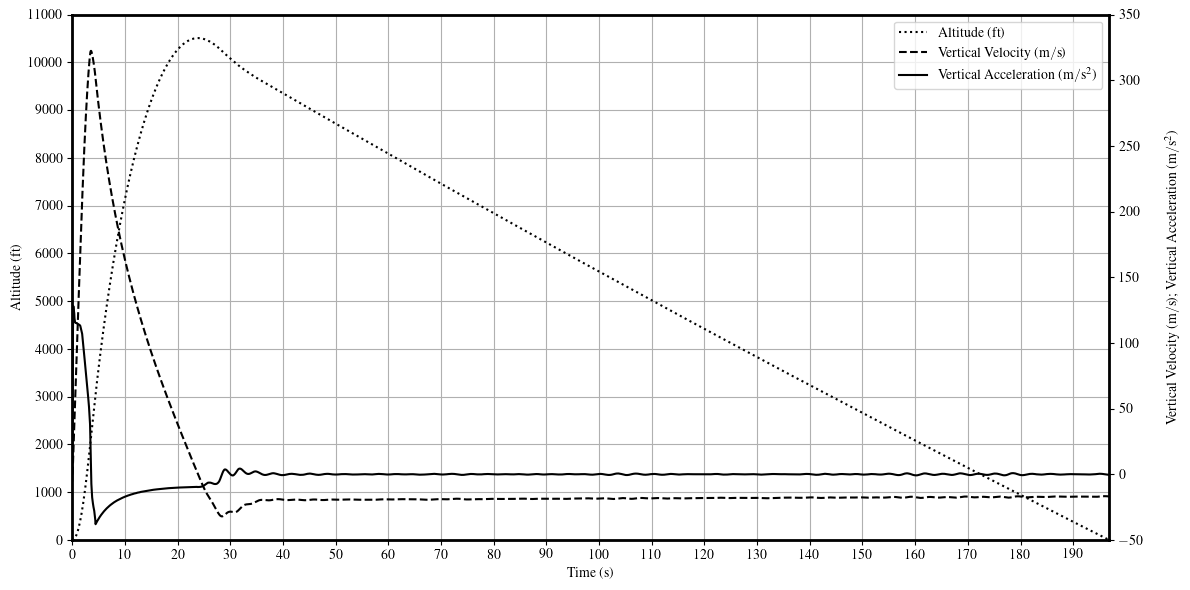

In [9]:
# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Altitude
ax1.plot(dh.merged_df["time"], dh.merged_df["altitude"],
         "k:", label="Altitude ($\mathrm{ft}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Altitude ($\mathrm{ft}$)")
ax1.set_xlim(0, dh.merged_df["time"].max())
ax1.set_ylim(0, max_altitude)
ax1.set_yticks(range(0, max_altitude + 1, ALTITUDE_INCREMENTS))
# Set x-axis ticks at regular intervals
ax1.set_xticks(np.arange(0, dh.merged_df["time"].max(), 10))
ax1.grid(True)

# Plot Vertical velocity and acceleration
ax2 = ax1.twinx()
ax2.plot(
    dh.merged_df["time"],
    dh.merged_df["vertical_velocity"],
    "k--",
    label="Vertical Velocity ($\mathrm{m/s}$)"
)
ax2.plot(
    dh.merged_df["time"],
    dh.merged_df["vertical_acceleration"],
    "k-",
    label="Vertical Acceleration ($\mathrm{m/s^2}$)"
)
ax2.set_ylabel(
    "Vertical Velocity ($\mathrm{m/s}$); Vertical Acceleration ($\mathrm{m/s^2}$)", labelpad=15
)
ax2.set_ylim(min_vertical_motion, max_vertical_motion)
ax2.set_yticks(
    np.arange(
        min_vertical_motion,
        max_vertical_motion + 1,
        VERTICAL_MOTION_INCREMENTS,
    )
)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

fig.tight_layout()

# # Plot event markers
# self.plot_event_markers(ax1)

plt.show()

# Open Rocket Flight Profile to Apogee

In [10]:
temp_or_df = dh.merged_df.copy(deep=True)
temp_or_df = temp_or_df[temp_or_df["time"]
                        <= APOGEE_TIME]

max_altitude = round_to_increment(
    dh.merged_df["altitude"], ALTITUDE_INCREMENTS, 'up')
max_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].max(), VERTICAL_MOTION_INCREMENTS, 'up')
min_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].min(), VERTICAL_MOTION_INCREMENTS, 'down')

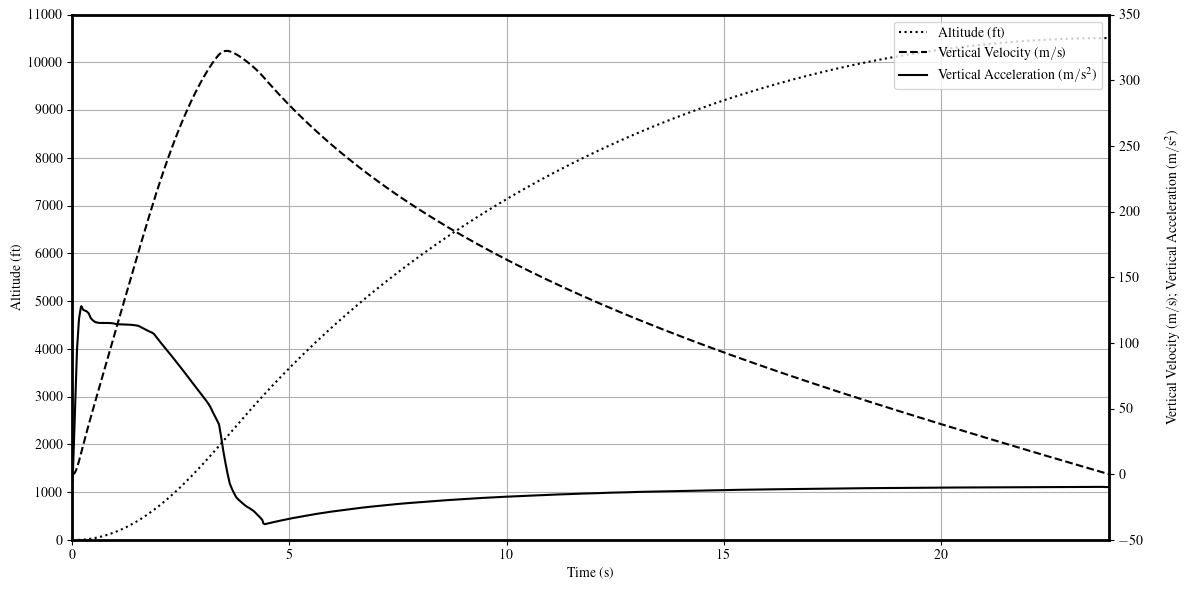

In [11]:
# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Altitude
ax1.plot(temp_or_df["time"], temp_or_df["altitude"],
         "k:", label="Altitude ($\mathrm{ft}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Altitude ($\mathrm{ft}$)")
ax1.set_xlim(0, APOGEE_TIME)
ax1.set_ylim(0, max_altitude)
ax1.set_yticks(range(0, max_altitude + 1, ALTITUDE_INCREMENTS))
# Set x-axis ticks at regular intervals
ax1.set_xticks(np.arange(0, APOGEE_TIME, 5))
ax1.grid(True)

# Plot Vertical velocity and acceleration
ax2 = ax1.twinx()
ax2.plot(
    temp_or_df["time"],
    temp_or_df["vertical_velocity"],
    "k--",
    label="Vertical Velocity ($\mathrm{m/s}$)",
)
ax2.plot(
    temp_or_df["time"],
    temp_or_df["vertical_acceleration"],
    "k-",
    label="Vertical Acceleration ($\mathrm{m/s^2}$)",
)
ax2.set_ylabel(
    "Vertical Velocity ($\mathrm{m/s}$); Vertical Acceleration ($\mathrm{m/s^2}$)", labelpad=15
)
ax2.set_ylim(min_vertical_motion, max_vertical_motion)
ax2.set_yticks(
    np.arange(
        min_vertical_motion,
        max_vertical_motion + 1,
        VERTICAL_MOTION_INCREMENTS,
    )
)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# plt.title(FLIGHT_PROFILE_PLOT_TITLE)
fig.tight_layout()

# # Plot event markers
# self.plot_event_markers(ax1)

plt.show()

# RasAero Flight Profile

In [12]:
max_altitude = round_to_increment(
    dh.ras_df["altitude"], ALTITUDE_INCREMENTS, 'up')
max_vertical_motion = round_to_increment(
    dh.ras_df[VERTICAL_MOTION_COLUMNS].max(), VERTICAL_MOTION_INCREMENTS, 'up')
min_vertical_motion = round_to_increment(
    dh.ras_df[VERTICAL_MOTION_COLUMNS].min(), VERTICAL_MOTION_INCREMENTS, 'down')

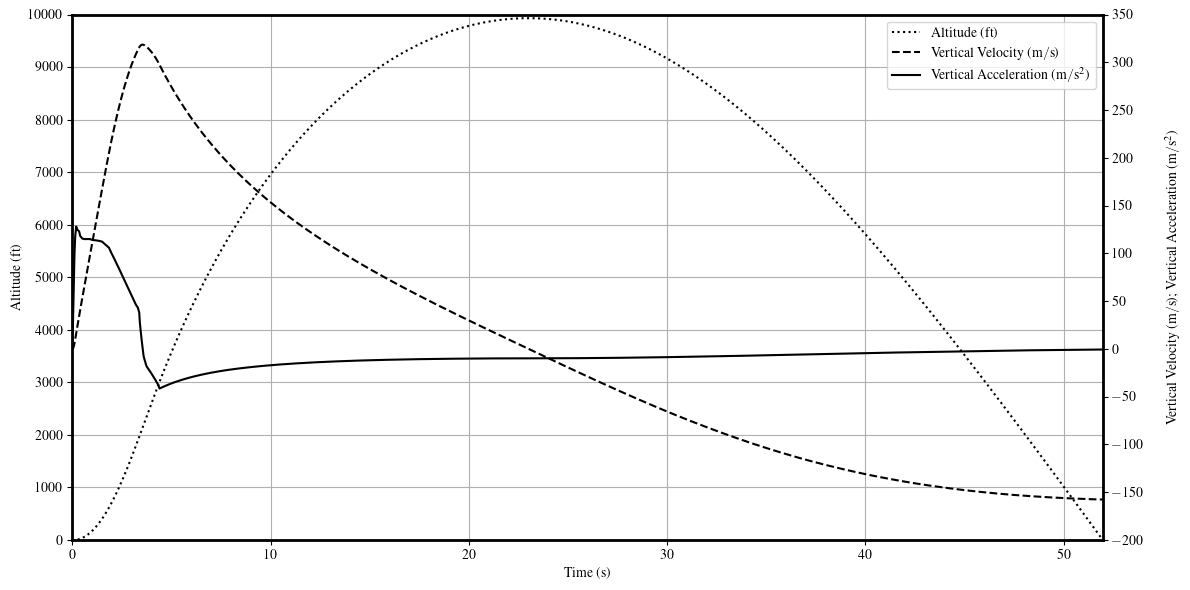

In [13]:
# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Altitude
ax1.plot(dh.ras_df["time"], dh.ras_df["altitude"],
         "k:", label="Altitude ($\mathrm{ft}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Altitude ($\mathrm{ft}$)")
ax1.set_xlim(0, dh.ras_df["time"].max())
ax1.set_ylim(0, max_altitude)
ax1.set_yticks(range(0, max_altitude + 1, ALTITUDE_INCREMENTS))
# Set x-axis ticks at regular intervals
ax1.set_xticks(np.arange(0, dh.ras_df["time"].max(), 10))
ax1.grid(True)

# Plot Vertical velocity and acceleration
ax2 = ax1.twinx()
ax2.plot(
    dh.ras_df["time"],
    dh.ras_df["vertical_velocity"],
    "k--",
    label="Vertical Velocity ($\mathrm{m/s}$)",
)
ax2.plot(
    dh.ras_df["time"],
    dh.ras_df["vertical_acceleration"],
    "k-",
    label="Vertical Acceleration ($\mathrm{m/s^2}$)",
)
ax2.set_ylabel(
    "Vertical Velocity ($\mathrm{m/s}$); Vertical Acceleration ($\mathrm{m/s^2}$)", labelpad=15
)
ax2.set_ylim(min_vertical_motion, max_vertical_motion)
ax2.set_yticks(
    np.arange(
        min_vertical_motion,
        max_vertical_motion + 1,
        VERTICAL_MOTION_INCREMENTS,
    )
)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# plt.title(FLIGHT_PROFILE_PLOT_TITLE)
fig.tight_layout()

# # Plot event markers
# self.plot_event_markers(ax1)

plt.show()

# RasAero Mach vs Cd

In [14]:
max_drag = math.ceil(dh.filtered_ras_df["drag_coefficient"].max() * 10) / 10
max_mach = math.ceil(dh.filtered_ras_df["mach_number"].max() * 10) / 10

# Find the data range for the drag coefficient
min_drag_coefficient = dh.filtered_ras_df["drag_coefficient"].min()
max_drag_coefficient = dh.filtered_ras_df["drag_coefficient"].max()

# Add a buffer to the min and max
buffer = (max_drag_coefficient - min_drag_coefficient) * 0.1  # 10% buffer
min_limit = max(min_drag_coefficient - buffer, 0)  # Avoid negative lower limit
max_limit = max_drag_coefficient + buffer

max_drag_rounded = math.ceil(max_limit * 10) / 10
min_drag_rounded = math.floor(min_limit * 10) / 10

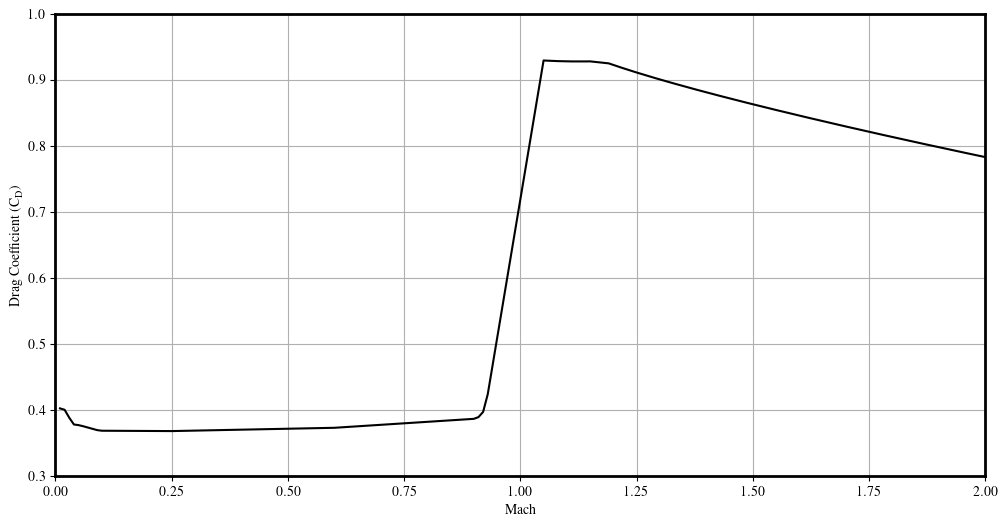

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))
        
ax1.set_xlabel(r"Mach")
ax1.set_ylabel(r"Drag Coefficient ($\mathrm{C_D}$)")
ax1.grid(True)
ax1.plot(dh.filtered_ras_df["mach_number"],
            dh.filtered_ras_df["drag_coefficient"], color='k', label="Drag Coefficient")
ax1.set_ylim(min_drag_rounded, max_drag_rounded)
ax1.set_xlim(0,max_mach)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# ax1.set_yticks(np.arange(0, max_drag+0.1, 0.05))

# Plot event markers
# self.plot_event_markers_mach(ax1)

plt.show()

# OpenRocket & RasAero Mach vs Cd

In [16]:
temp_ras_df = dh.filtered_ras_df.copy(deep=True)
temp_ras_df = temp_ras_df[temp_ras_df["mach_number"]
                          <= MAX_MACH_RAS_OR_COMPARISON]

max_drag = math.ceil(temp_ras_df["drag_coefficient"].max() * 10) / 10
max_mach = math.ceil(temp_ras_df["mach_number"].max() * 10) / 10

# Find the data range for the drag coefficient
min_drag_coefficient = temp_ras_df["drag_coefficient"].min()
max_drag_coefficient = temp_ras_df["drag_coefficient"].max()

# Add a buffer to the min and max
buffer = (max_drag_coefficient - min_drag_coefficient) * 0.1  # 10% buffer
min_limit = max(min_drag_coefficient - buffer, 0)  # Avoid negative lower limit
max_limit = max_drag_coefficient + buffer

max_drag_rounded = math.ceil(max_limit * 10) / 10
min_drag_rounded = math.floor(min_limit * 10) / 10

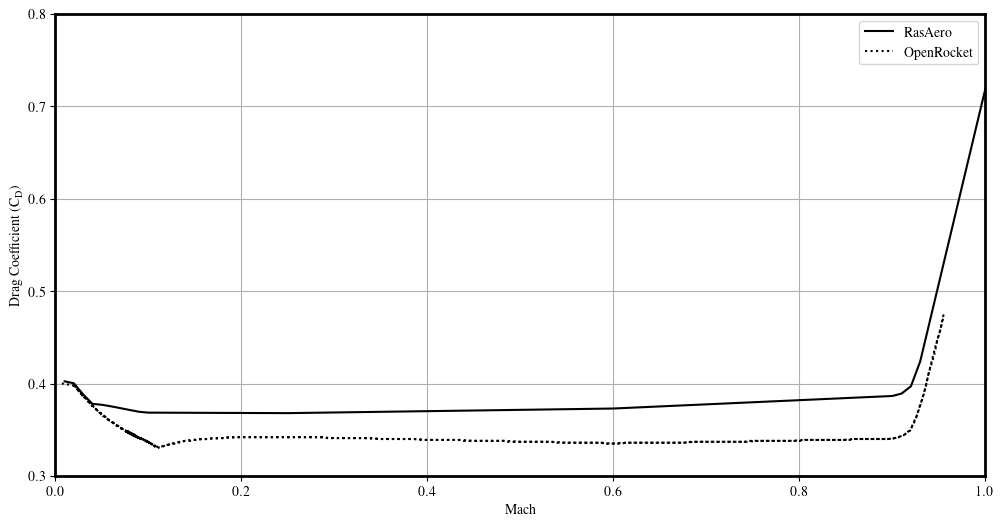

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel(r"Mach")
ax1.set_ylabel(r"Drag Coefficient ($\mathrm{C_D}$)")
ax1.grid(True)
ax1.plot(temp_ras_df["mach_number"],
         temp_ras_df["drag_coefficient"], color='k', linestyle='-', label="RasAero")
ax1.plot(dh.merged_df["mach_number"],
         dh.merged_df["drag_coefficient"], color='k', linestyle=':', label="OpenRocket")
ax1.set_ylim(min_drag_rounded, max_drag_rounded)
ax1.set_xlim(0, MAX_MACH_RAS_OR_COMPARISON)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Adding the legend
plt.legend()

# ax1.set_yticks(np.arange(0, max_drag+0.1, 0.05))

# Plot event markers
# self.plot_event_markers_mach(ax1)

plt.show()

# Stability vs Time

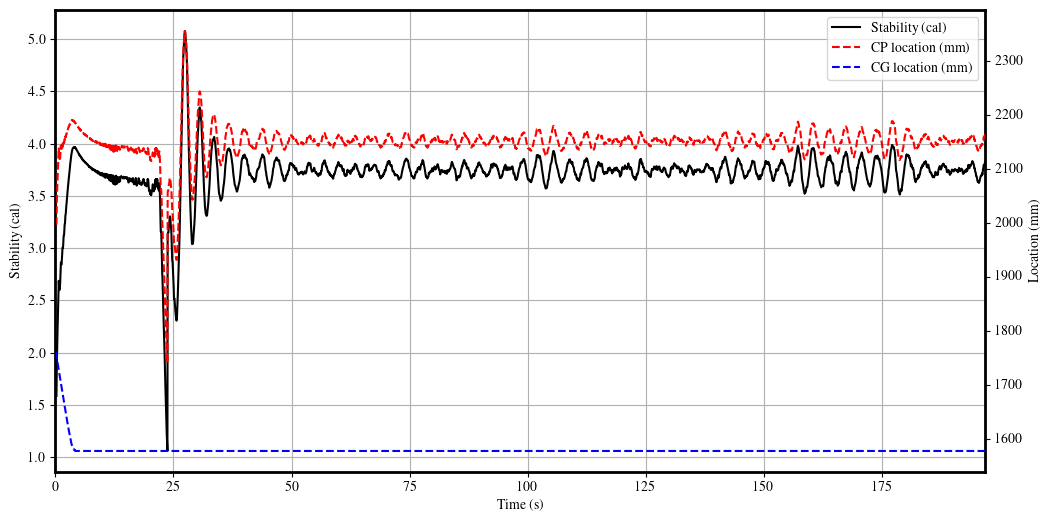

In [18]:
"""Plot Stability data."""
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")

ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax1.grid(True)

# Plot CP and CG location on a secondary axis
ax2 = ax1.twinx()
ax2.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
         "r--", label="CP location ($\mathrm{mm}$)")
ax2.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
         "b--", label="CG location ($\mathrm{mm}$)")
ax2.set_ylabel("Location ($\mathrm{mm}$)")

# Set x-axis limits based on SHOW_FULL_STABILITY_GRAPH
ax1.set_xlim(0, dh.merged_df["time"].max())

# Combine legends from ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Plot event markers
# self.plot_event_markers(ax1)

# plt.title(f"{self.MOTOR_NAME} Motor - {y_label} vs Time(s)")
plt.show()

# Stability vs Time Calibers

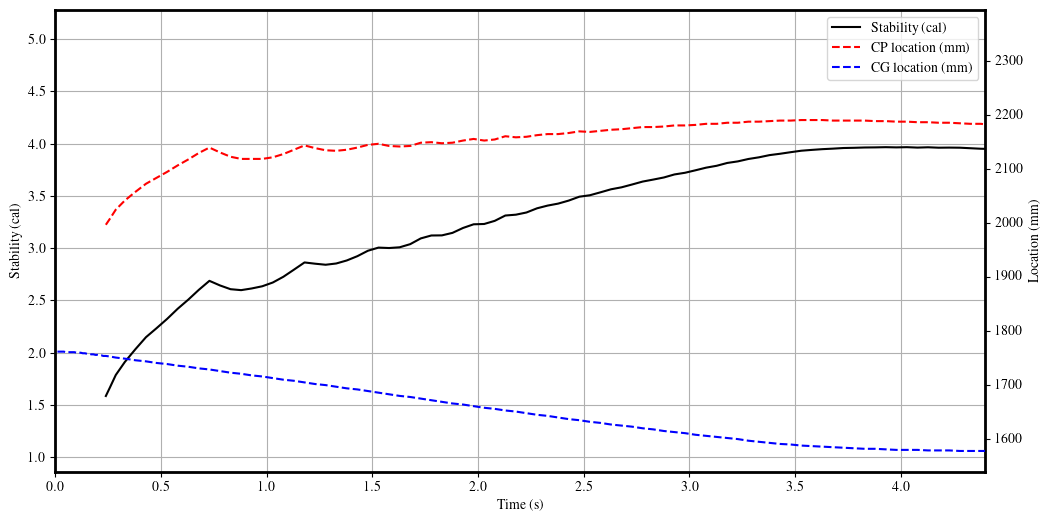

In [19]:
"""Plot Stability data."""
fig, ax1 = plt.subplots(figsize=(12, 6))

# Select y-axis data based on STABILITY_UNIT and plot
ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")

ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax1.grid(True)

# Plot CP and CG location on a secondary axis
ax2 = ax1.twinx()
ax2.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
         "r--", label="CP location ($\mathrm{mm}$)")
ax2.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
         "b--", label="CG location ($\mathrm{mm}$)")
ax2.set_ylabel("Location ($\mathrm{mm}$)")

ax1.set_xlim(0, BURNOUT_TIME)

# Combine legends from ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Plot event markers
# self.plot_event_markers(ax1)
plt.show()

# Stability vs Time Percentage

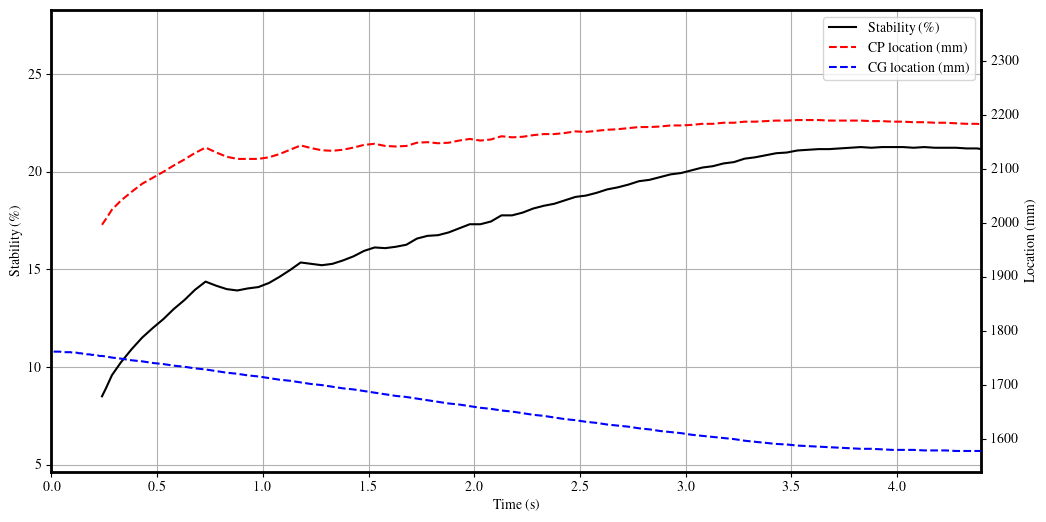

In [20]:
"""Plot Stability data."""
fig, ax1 = plt.subplots(figsize=(12, 6))

# Select y-axis data based on STABILITY_UNIT and plot
ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_percentage"],
         "k-", label="Stability ($\mathrm{\%}$)")

ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{\%}$)")
ax1.grid(True)

# Plot CP and CG location on a secondary axis
ax2 = ax1.twinx()
ax2.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
         "r--", label="CP location (mm)")
ax2.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
         "b--", label="CG location (mm)")
ax2.set_ylabel("Location (mm)")

# Set x-axis limits based on SHOW_FULL_STABILITY_GRAPH
ax1.set_xlim(0, BURNOUT_TIME)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends from ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Plot event markers
# self.plot_event_markers(ax1)

plt.show()

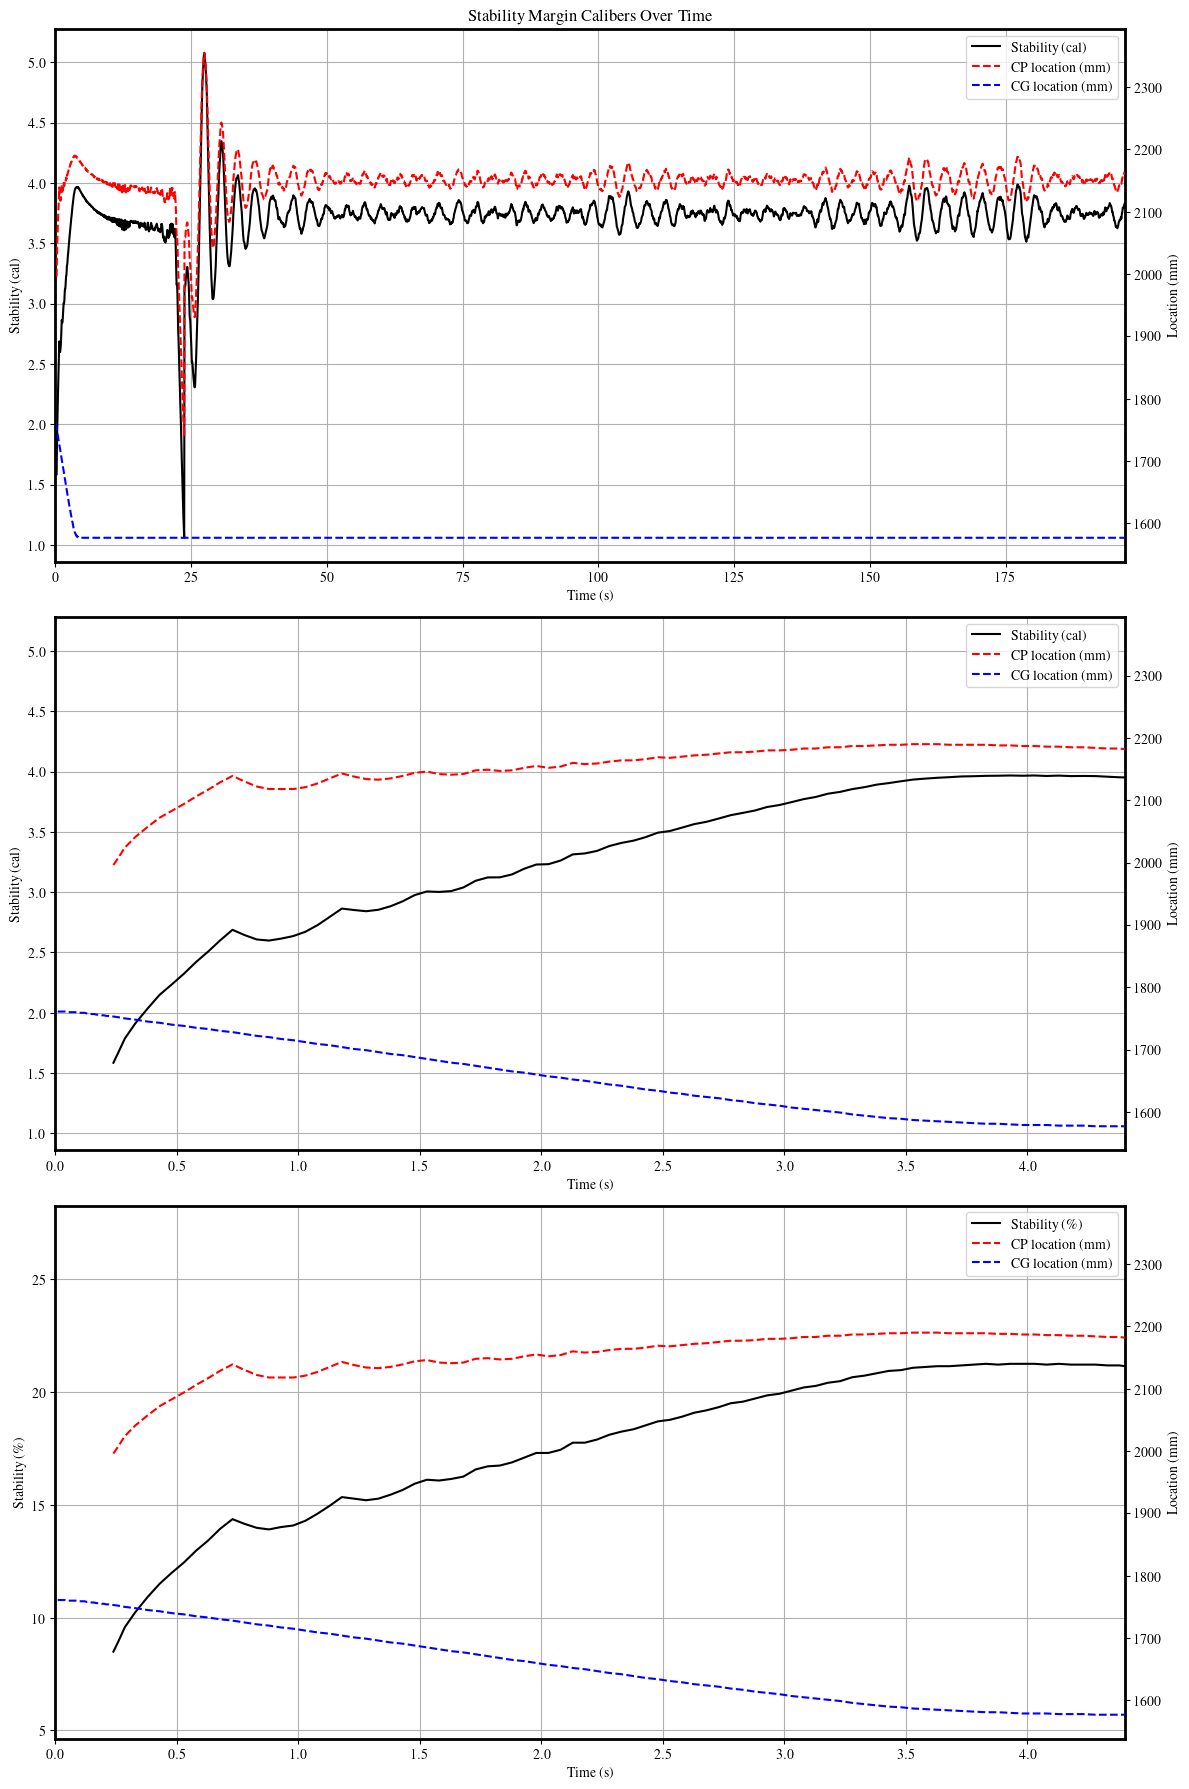

In [22]:
# Create a figure with 3 subplots (rows) and 1 column
fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # Adjust the figsize as needed

# First subplot
ax1 = axs[0]
ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax1.grid(True)
ax1.set_xlim(0, dh.merged_df["time"].max())
# Set title for the first subplot
ax1.set_title("Stability Margin Calibers Over Time")

# Second subplot
ax2 = axs[1]
ax2.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")
ax2.set_xlabel(r"Time ($\mathrm{s}$)")
ax2.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax2.grid(True)
ax2.set_xlim(0, BURNOUT_TIME)

# Third subplot
ax3 = axs[2]
ax3.plot(dh.merged_df["time"], dh.merged_df["stability_margin_percentage"],
         "k-", label="Stability ($\mathrm{\%}$)")
ax3.set_xlabel(r"Time ($\mathrm{s}$)")
ax3.set_ylabel(r"Stability ($\mathrm{\%}$)")
ax3.grid(True)
ax3.set_xlim(0, BURNOUT_TIME)

# Common settings for all subplots
for ax in axs:
    # Adjust spine properties
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # Add secondary axis for CP and CG location
    ax_sec = ax.twinx()
    ax_sec.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
                "r--", label="CP location (mm)")
    ax_sec.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
                "b--", label="CG location (mm)")
    ax_sec.set_ylabel("Location (mm)")

    # Combine legends from primary and secondary axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_sec.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper right")

plt.tight_layout()  # Adjust layout
plt.show()